In [ ]:
import pandas as pd
import networkx as nx
import backboning as bb  # assuming backboning.py is in your PYTHONPATH
from pathlib import Path
import matplotlib.pyplot as plt
import plotly.express as px


In [1]:

import pandas as pd
import networkx as nx
import backboning as bb  # assuming backboning.py is in your PYTHONPATH

def nc_backbone_from_nx(G, weight_attr="weight", threshold=2.0, calculate_p_value=False):
    """
    Compute Noise-Corrected backbone from an undirected NetworkX graph.

    Args:
        G (nx.Graph): Undirected weighted graph.
        weight_attr (str): Edge attribute name for weights.
        threshold (float): Threshold for backbone extraction.
        calculate_p_value (bool): If True, compute p-values instead of NC score.

    Returns:
        backbone_edges (pd.DataFrame): DataFrame with columns [src, trg, nij, score].
    """
    # 1. Convert NetworkX graph to DataFrame
    edges = []
    for u, v, data in G.edges(data=True):
        w = data.get(weight_attr, 1.0)  # default weight = 1 if missing
        edges.append({"src": u, "trg": v, "weight": w})
    df = pd.DataFrame(edges)

    # 2. Compute NC backbone
    nc_table = bb.noise_corrected(
        df.rename(columns={"weight": "nij"}),  # rename for compatibility
        undirected=True,
        return_self_loops=False,
        calculate_p_value=calculate_p_value
    )

    # 3. Apply thresholding
    backbone = bb.thresholding(nc_table, threshold)

    return backbone

# Example usage:
# G = nx.read_weighted_edgelist("mygraph.edgelist")  # or any nx.Graph
# backbone_df = nc_backbone_from_nx(G, weight_attr="weight", threshold=2.0)
# print(backbone_df.head())


In [3]:
# import original graph
path = Path(r"/Users/iben/Desktop/Social_graphs/SocialGraphs/Project/MUSIC/artist_network.graphml")

G_lyrics = nx.read_graphml(path)

# number of nodes and edges
print(f"Original graph has {G_lyrics.number_of_nodes()} nodes and {G_lyrics.number_of_edges()} edges.")


Original graph has 1015 nodes and 63840 edges.


In [29]:
# creat NC backbone
NC_backbone = nc_backbone_from_nx(G_lyrics, weight_attr="weight", threshold=3.0, calculate_p_value=False)

Calculating NC score...


In [30]:
# number of nodes and edges in NC backbone
print(f"NC Backbone has {NC_backbone.shape[0]} edges.")

NC Backbone has 16333 edges.


In [31]:
print(NC_backbone)

                    src                  trg  nij     score
13        Missy_Elliott                Ne-Yo    1  0.809201
14        Missy_Elliott        Nelly_Furtado    3  0.979738
15        Missy_Elliott              Omarion    1  0.971056
16        Missy_Elliott              OutKast    2  0.959456
17        Missy_Elliott               Shaggy    2  0.978867
...                 ...                  ...  ...       ...
63832           Bayside   I_Am_The_Avalanche    1  0.999865
63833          Quintino               Tujamo    1  0.999713
63836       Jagged_Edge             Makaveli    1  0.999155
63838  Claudelle_Clarke  The_Grace_Thrillers    1  0.999949
63839          Makaveli            Thug_Life    1  0.999916

[16333 rows x 4 columns]


In [32]:
# make a networkx graph from the backbone dataframe
G_NC_backbone = nx.from_pandas_edgelist(NC_backbone, source='src', target='trg', edge_attr='nij')
print(G_NC_backbone)

Graph with 1004 nodes and 16333 edges


In [33]:
# top 10 artists by degree in NC backbone
degree_dict = dict(G_NC_backbone.degree())
top_10_artists = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:10]
print(top_10_artists)

# top 10 weighted edges in NC backbone
weighted_edges = nx.get_edge_attributes(G_NC_backbone, 'nij')
top_10_weighted_edges = sorted(weighted_edges.items(), key=lambda x: x[1], reverse=True)[:10]
print(top_10_weighted_edges)


[('Yeah_Yeah_Yeahs', 92), ('David_Bowie', 83), ('Billy_Joel', 81), ('Lana_Del_Rey', 80), ('A_R_I_Z_O_N_A', 79), ('Aerosmith', 79), ('Coldplay', 78), ('The_Shins', 78), ('The_xx', 77), ('Eagles', 77)]
[(('Drake', 'The_Weeknd'), 47), (('Drake', 'Kanye_West'), 45), (('Rihanna', 'The_Weeknd'), 35), (('Drake', 'Kendrick_Lamar'), 34), (('Drake', 'Future'), 31), (('Rae_Sremmurd', 'Big_Sean'), 30), (('Drake', 'Rae_Sremmurd'), 29), (('Rihanna', 'Chris_Brown'), 28), (('Chris_Brown', 'Drake'), 28), (('Major_Lazer', 'The_Chainsmokers'), 28)]


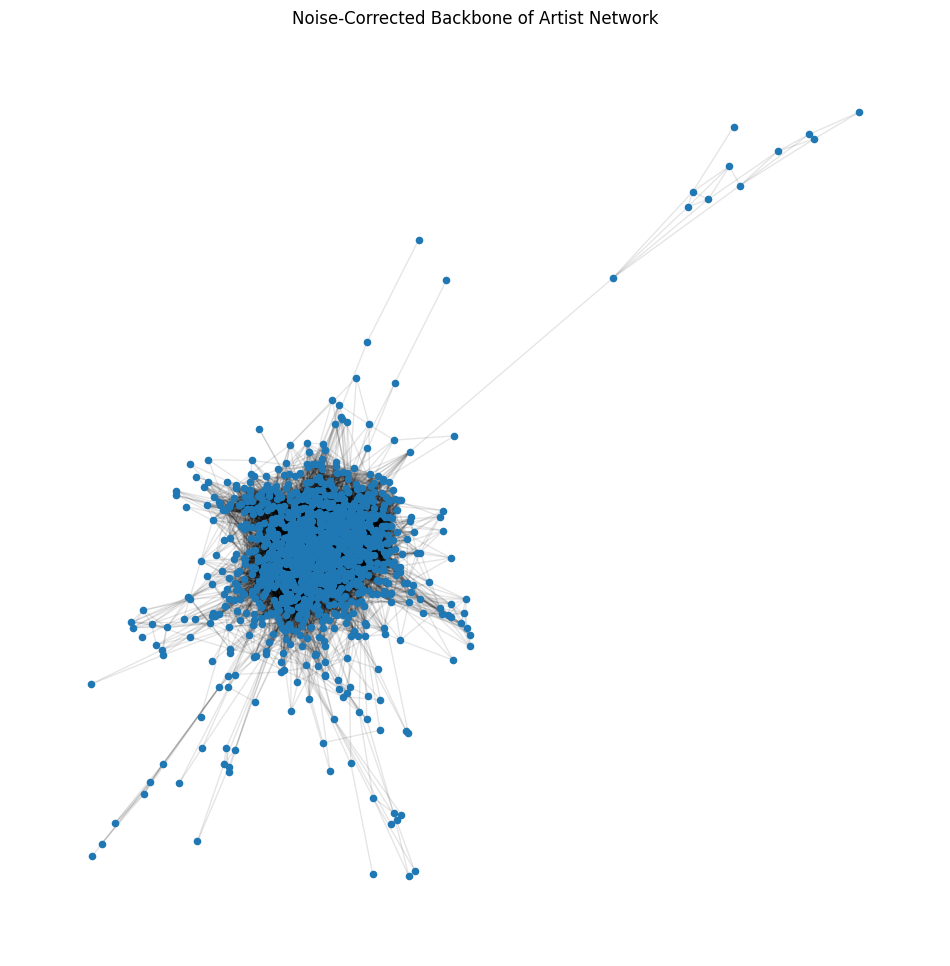

In [34]:
# plot NC backbone
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G_NC_backbone, k=0.1)  # positions for all nodes
nx.draw_networkx_nodes(G_NC_backbone, pos, node_size=20)
nx.draw_networkx_edges(G_NC_backbone, pos, alpha=0.1)
plt.title("Noise-Corrected Backbone of Artist Network")
plt.axis('off')
plt.show()

In [ ]:
def plot_nc_backbone_thresholds(G, weight_attr="weight", thresholds=None):
    if thresholds is None:
        thresholds = [0.5, 1, 1.5, 2, 2.5, 3]

    # Convert NetworkX graph to DataFrame
    edges = [{"src": u, "trg": v, "nij": data.get(weight_attr, 1.0)}
             for u, v, data in G.edges(data=True)]
    df = pd.DataFrame(edges)

    # Compute NC scores
    nc_table = bb.noise_corrected(df, undirected=True, return_self_loops=False)

    # Calculate edge counts for each threshold
    edge_counts = []
    for t in thresholds:
        backbone = bb.thresholding(nc_table, t)
        edge_counts.append(len(backbone))

    # Plot using Plotly
    fig = px.line(x=thresholds, y=edge_counts, markers=True,
                  labels={'x': 'Threshold', 'y': 'Number of Edges'},
                  title='NC Backbone Edge Count vs Threshold')
    fig.show()

    return thresholds, edge_counts

# Example usage:
# G = nx.read_weighted_edgelist("mygraph.edgelist")
# plot_nc_backbone_thresholds(G)


ModuleNotFoundError: No module named 'plotly'